# PSEUDo vs. UTS metrics: PEAX Data

In this experiment we will compare the LSH algorithm of PSEUDo to other state of the art time series search strategies using a genome dataset used in PEAX. The main purpose of this experiment is to compare the **computing time** of all strategies.

We will compare the following 5 search strategies:
- PEAX feature reduction -> eucledian distance
- SAX feature reduction -> eucledian distance
- PSEUDo LSH strategy
- DTW distance
- Eucledian distance

## Data preparation

In [1]:
import numpy as np
import json
import h5py
import os
import sys
from time import time
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'

In [2]:
from download import download_encode_file, download_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)

download_encode_file('ENCFF158GBQ.bigWig')

download_file(
    "https://zenodo.org/record/2609763/files/dnase_w-12000_r-100.h5?download=1",
    "dnase_w-12000_r-100.h5",
    dir="models"
)

./data/ENCFF158GBQ.bigWig already exist. To overwrite pass `overwrite=True`
./models/dnase_w-12000_r-100.h5 already exist. To overwrite pass `overwrite=True`


Then we split the data into subwindows of 12kb, with a stepsize of 2kb. These subwindows are reduced to a size of 120.

In [3]:
import bigwig

t0 = time()
data_12kb = np.array(bigwig.chunk(bw, 12000, 100, 12000 / 6, ['chr1'], verbose=True), dtype="float32")

print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Extracted 124621 windows from chr1 with a max value of 1.0.
Done! Took 25.32 seconds (0.4 minutes).


We then artificially generate a **multivariate** time series from the original data. We do this by using the same windows and randomly shuffling these windows to create a new track

In [4]:
track1 = np.arange(124621)
track2 = np.arange(124621)
track3 = np.arange(124621)

np.random.shuffle(track2)
np.random.shuffle(track3)

data_multivariate = np.array([[[data_12kb[track1[i]][j], data_12kb[track2[i]][j], data_12kb[track2[i]][j]] for j in list(range(120))] for i in list(range(124621))])
print(data_multivariate.shape)

(124621, 120, 3)


Set the target queries. These targets are selected because they show visually easy to compare patterns.

In [5]:
from utils import plot_windows_from_data

k_12kb = 20 # Number of KNNs to be saved later on
targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]

In [6]:
from scipy.spatial.distance import cdist

def knn(data, target_idx, k, metric='euclidean', sax = None, ignore: int = 0, sort_only: bool = False):
    """K nearest neighbors
    
    Find the `k` nearest neighbors of a 
    """
    
    target = data[target_idx]
    
    if sort_only:
        dist = data
    else:
        if sax is None:
            dist = cdist(data, target.reshape((1, target.size)), metric='euclidean').flatten()

        else:
            N = data.shape[0]
            dist = np.zeros(N)
            for i in range(N):
                dist[i] = sax.distance_sax(target, data[i])

    # Ensure that the target is always first
    dist[target_idx] = -1
    for i in range(1, ignore + 1):
        dist[min(target_idx + i, data.shape[0] - 1)] = -1
        dist[max(target_idx - i, 0)] = -1
        
    print(np.argsort(dist)[0:5])
    
    return np.argsort(dist)

## CAE

In [7]:
from utils import get_models, predict

encoder_12kb, decoder_12kb, autoencoder_12kb = get_models('models/dnase_w-12000_r-100.h5', loss_fn='bce')

t0 = time()
predicted_12kb, _, latent_12kb = predict(
    encoder_12kb,
    decoder_12kb,
    data_12kb.reshape(data_12kb.shape[0], data_12kb.shape[1], 1)
)
peax_preprocess_time = time() - t0
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
latent_12kb = np.array([np.append(latent_12kb[track1[i]], [latent_12kb[track2[i]], latent_12kb[track3[i]]]) for i in range(124621)])

Done! Took 87.75 seconds (1.5 minutes).


In [8]:
from time import time
l2_time = 0
peax_time = 0
all_peax_candidates = []
t0 = time()
for i, target in enumerate(targets_12kb):
    all_peax_candidates.append(knn(latent_12kb, target, k_12kb, ignore=0))
peax_time = time()-t0
print('. done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

[80503 77453 78224   765 12624]
[ 43895 117428   3131    482  12114]
[ 33430   9522    551 101524 114064]
[42575 21050 75507 80639 22527]
[  6112  12677 113441   5345 106389]
[ 91938 122983 104019   1091   1804]
[82896 12151 13411  3173  6067]
[ 1060 12623 80504 56621  8878]
[ 11975 102060  55300  47085   1728]
. done! Took 0.28 seconds (0.0 minutes).


## SAX

In [9]:
from tslearn.piecewise import SymbolicAggregateApproximation

t0 = time()
sax_12kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_12kb = sax_12kb.fit_transform(data_multivariate)
print('Preprocessing done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
sax_preprocess_time = time() - t0

Preprocessing done! Took 100.72 seconds (1.7 minutes).


In [10]:
t0 = time()
N = sax_data_12kb.shape[0]
all_sax_candidates = []
for target in targets_12kb:
    t1 = time()
    sax_distances = [sax_12kb.distance_sax(sax_data_12kb[target], window) for window in sax_data_12kb]
    sax_candidates = sorted(range(len(sax_distances)), key=lambda k: sax_distances[k])
    all_sax_candidates.append(sax_candidates)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(target, time() - t1, (time() - t1) / 60))
sax_time = time() - t0
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #80503 done! Took 38.96 seconds (0.6 minutes).
Target #43895 done! Took 38.54 seconds (0.6 minutes).
Target #33430 done! Took 38.37 seconds (0.6 minutes).
Target #42575 done! Took 38.00 seconds (0.6 minutes).
Target #6112 done! Took 37.21 seconds (0.6 minutes).
Target #91938 done! Took 36.50 seconds (0.6 minutes).
Target #82896 done! Took 36.87 seconds (0.6 minutes).
Target #1060 done! Took 40.47 seconds (0.7 minutes).
Target #11975 done! Took 37.00 seconds (0.6 minutes).
Done! Took 341.92 seconds (5.7 minutes).


## PSEUDO

In [11]:
import sys
from time import time

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess
import _lsh

data_for_lsh = data_multivariate
print(data_for_lsh.shape)
print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data_for_lsh, 2.5)
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

lsh_preprocess_time = time() - t0

(124621, 120, 3)
Preprocessing:
r = 2.5
bigger
r = 6.25
smaller
r = 4.375
Mean: 4.86466318776131
Stdev: 0.8432015838981727
Ratio mean: 0.8508836494228631
Ratio stdev: 0.09776968340268126
Theta: 2.6892031013040243
r: 0.32596598185548115
Preprocessing time: 3.483684539794922
Preprocessing done. Took 3.48 seconds (0.1 minutes).


In [12]:
from collections import defaultdict
t0 = time()
total_lsh_times = []
all_lsh_candidates = []
for i, target in enumerate(targets_12kb):
    t1 = time()
    query = data_for_lsh[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data_for_lsh, query, r, a, sd, 0)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 13.90 seconds (0.2 minutes).
doing lsh
Target #1 done! Took 13.67 seconds (0.2 minutes).
doing lsh
Target #2 done! Took 13.83 seconds (0.2 minutes).
doing lsh
Target #3 done! Took 13.62 seconds (0.2 minutes).
doing lsh
Target #4 done! Took 13.76 seconds (0.2 minutes).
doing lsh
Target #5 done! Took 13.82 seconds (0.2 minutes).
doing lsh
Target #6 done! Took 13.78 seconds (0.2 minutes).
doing lsh
Target #7 done! Took 14.15 seconds (0.2 minutes).
doing lsh
Target #8 done! Took 13.90 seconds (0.2 minutes).
Done! Took 124.42 seconds (2.1 minutes).


In [13]:
from collections import defaultdict
t0 = time()
total_lsh_times_ed = []
all_lsh_candidates_ed = []
for i, target in enumerate(targets_12kb):
    t1 = time()
    query = data_for_lsh[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data_for_lsh, query, r, a, sd, 1)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times_ed.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates_ed.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 5.26 seconds (0.1 minutes).
doing lsh
Target #1 done! Took 5.14 seconds (0.1 minutes).
doing lsh
Target #2 done! Took 5.08 seconds (0.1 minutes).
doing lsh
Target #3 done! Took 5.08 seconds (0.1 minutes).
doing lsh
Target #4 done! Took 5.16 seconds (0.1 minutes).
doing lsh
Target #5 done! Took 5.07 seconds (0.1 minutes).
doing lsh
Target #6 done! Took 5.06 seconds (0.1 minutes).
doing lsh
Target #7 done! Took 5.13 seconds (0.1 minutes).
doing lsh
Target #8 done! Took 5.41 seconds (0.1 minutes).
Done! Took 46.40 seconds (0.8 minutes).


## DTW

In [14]:
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw_path_from_metric
from tslearn.metrics import dtw
from time import time

t0 = time()
all_dtw_candidates = []
total_dtw_times = []
for i, target in enumerate(targets_12kb):
    t1 = time()
    query = data_multivariate[target]
    dtw_distances = [dtw(window, query, global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * 120)) for window in data_multivariate]
    dtw_candidates = sorted(range(len(dtw_distances)), key=lambda k: dtw_distances[k])
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    total_dtw_times.append(time()-t1)
    all_dtw_candidates.append(dtw_candidates)
dtw_time = time() - t0
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 15.12 seconds (0.3 minutes).
Target #1 done! Took 15.20 seconds (0.3 minutes).
Target #2 done! Took 15.25 seconds (0.3 minutes).
Target #3 done! Took 15.04 seconds (0.3 minutes).
Target #4 done! Took 14.93 seconds (0.2 minutes).
Target #5 done! Took 15.00 seconds (0.3 minutes).
Target #6 done! Took 14.93 seconds (0.2 minutes).
Target #7 done! Took 14.83 seconds (0.2 minutes).
Target #8 done! Took 14.97 seconds (0.2 minutes).
Done! Took 135.27 seconds (2.3 minutes).


## ED

In [15]:
t0 = time()
all_ed_candidates = []
total_ed_times = []
t2 = time()
for i, target in enumerate(targets_12kb):
    t1 = time()
    query = data_multivariate[target]
    ed_distances = [np.linalg.norm(query-window) for window in data_multivariate]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    ed_candidates = sorted(range(len(ed_distances)), key=lambda k: ed_distances[k])
    total_ed_times.append(time()-t1)
    all_ed_candidates.append(ed_candidates)
l2_time += time()-t2
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 0.74 seconds (0.0 minutes).
Target #1 done! Took 0.72 seconds (0.0 minutes).
Target #2 done! Took 0.94 seconds (0.0 minutes).
Target #3 done! Took 0.70 seconds (0.0 minutes).
Target #4 done! Took 0.92 seconds (0.0 minutes).
Target #5 done! Took 0.72 seconds (0.0 minutes).
Target #6 done! Took 0.88 seconds (0.0 minutes).
Target #7 done! Took 0.90 seconds (0.0 minutes).
Target #8 done! Took 0.70 seconds (0.0 minutes).
Done! Took 7.86 seconds (0.1 minutes).


## Visual comparison

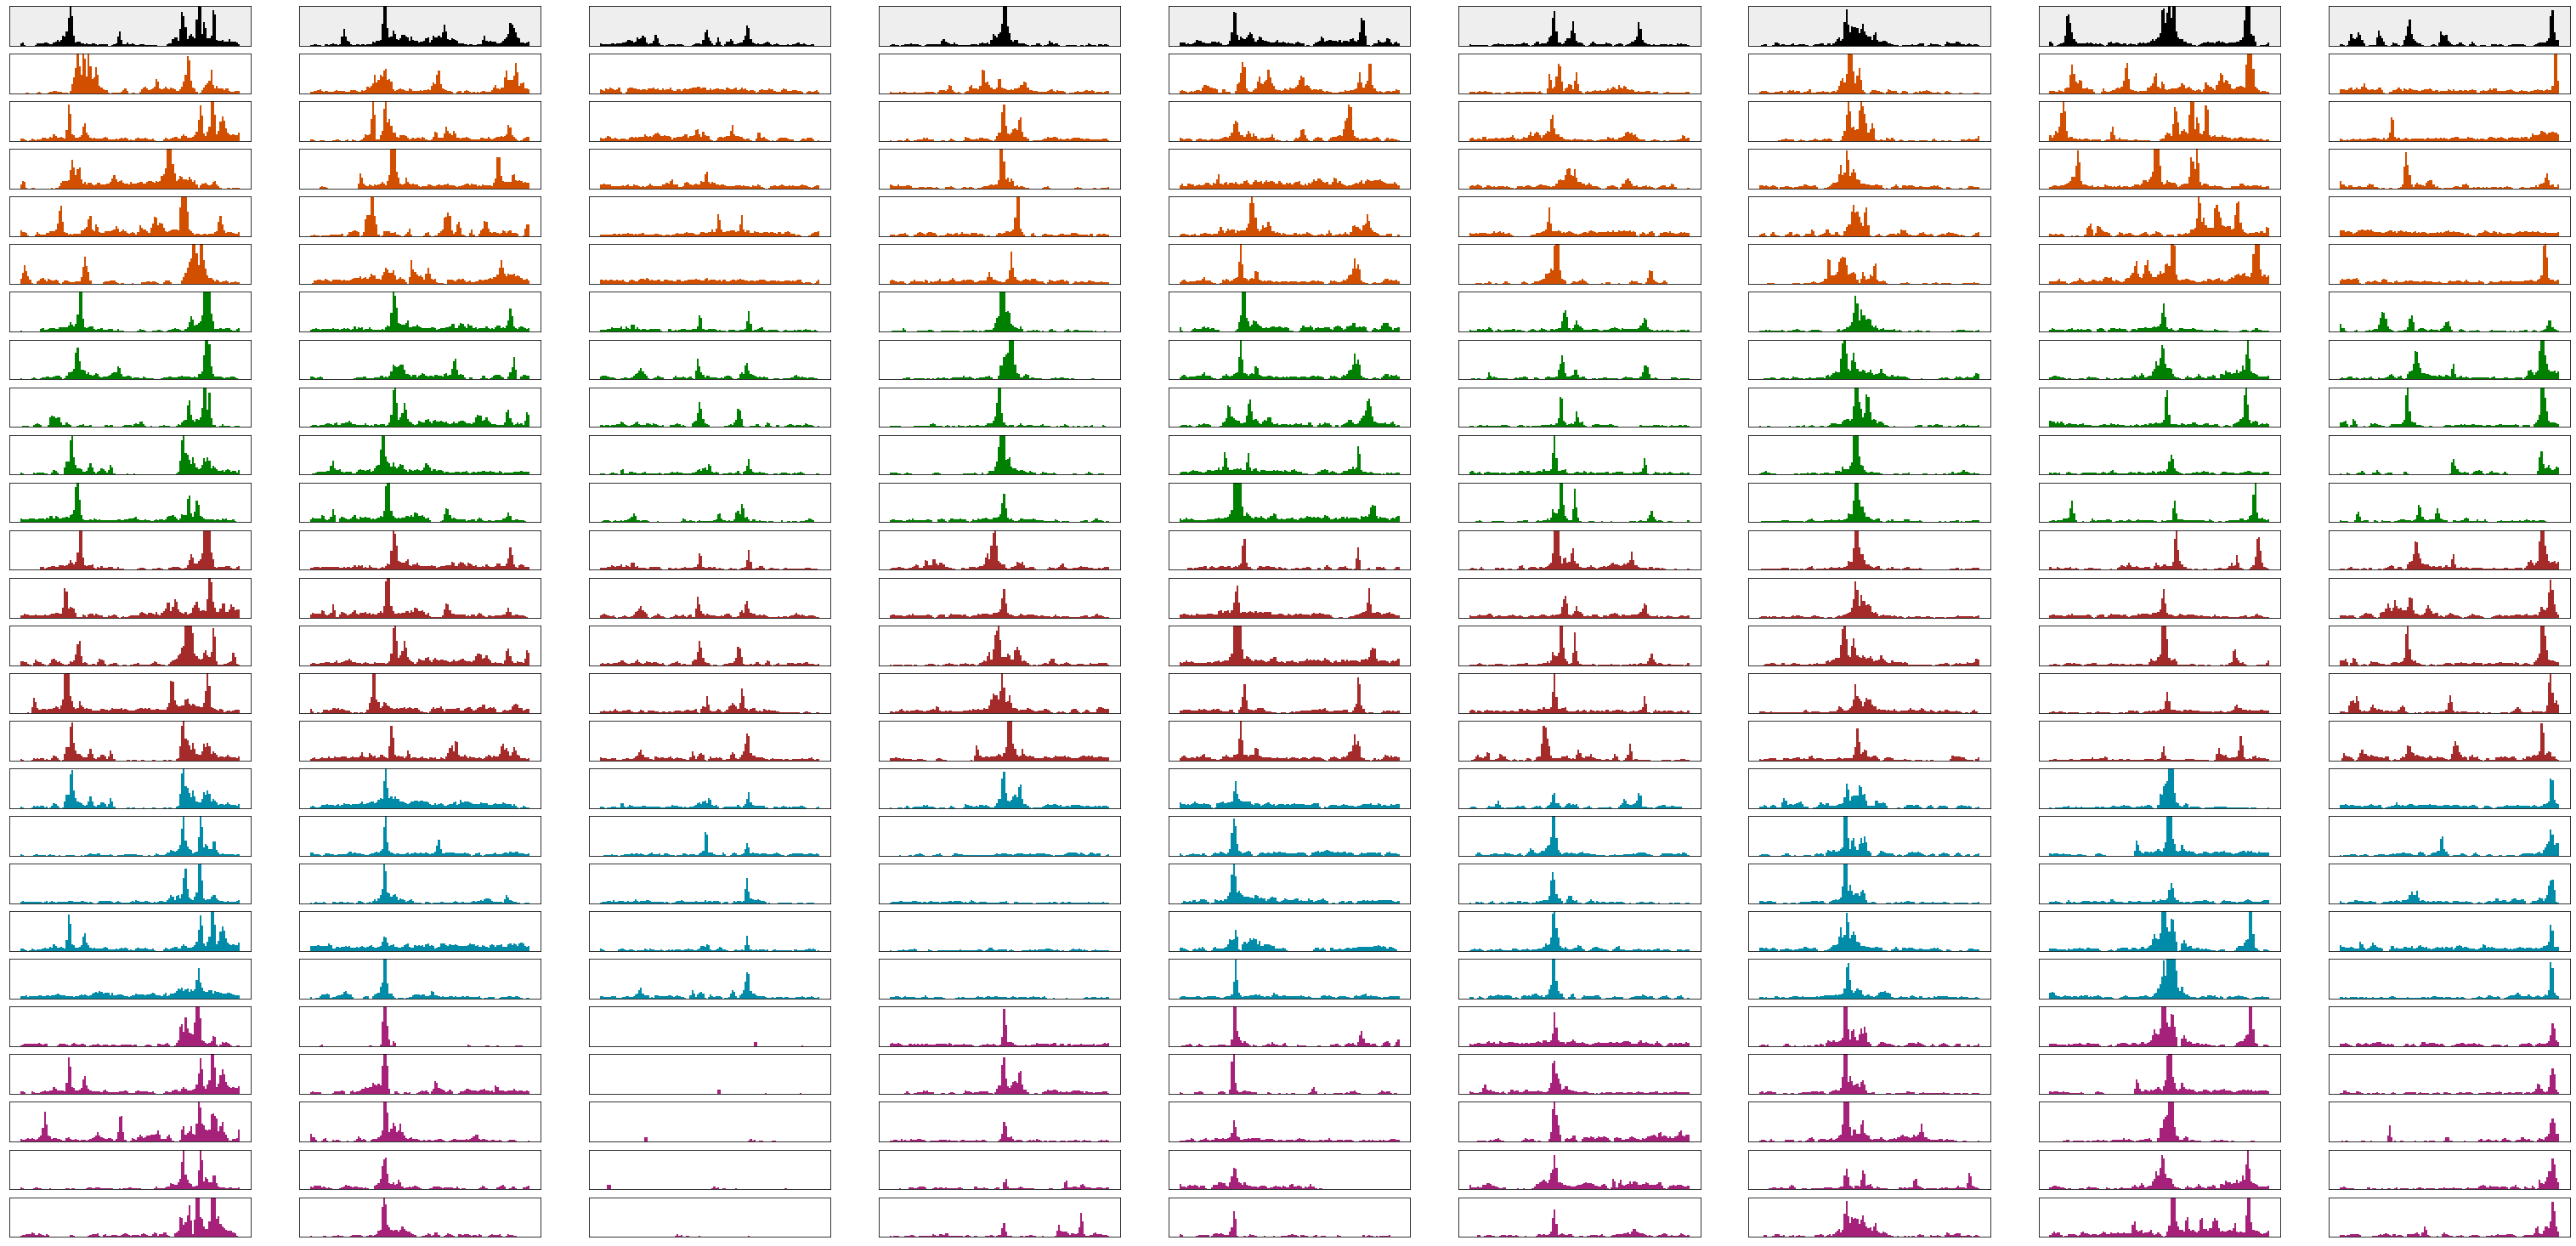

In [16]:
import h5py
import json
import matplotlib.pyplot as plt 
import numpy as np

show = 5

N = (show + 1) * 6

T = len(targets_12kb)
sz = data_12kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets_12kb):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#eeeeee")
    
    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_peax_candidates[i][1:][:show]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
        
    for j, hit in enumerate(all_lsh_candidates[i][1:][:show]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='green', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
        
    for j, hit in enumerate(all_dtw_candidates[i][1:][:show]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='brown', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
        
    for j, hit in enumerate(all_ed_candidates[i][1:][:show]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#008ca8', width=1.0) # blue = EQ
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(all_sax_candidates[i][1:][:show]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

In [17]:
k = 100
targets = targets_12kb
total_recall_pseudo = []
total_precision_pseudo = []
total_precision2_pseudo = []
total_pruned_pseudo = []
for i in range(len(targets)):
    print(len(all_lsh_candidates[i]))
    top_10_percent = int(len(all_lsh_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates[i])/len(all_peax_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_peax_candidates[i][0:k]:
        if index in all_lsh_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_peax_candidates[i][0:k]:
        if index in all_lsh_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates[i][0:k]:
        if index in all_peax_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo.append(pruned)
    total_recall_pseudo.append(recall/k)
    total_precision_pseudo.append(precision/k)
    total_precision2_pseudo.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo)) + "%")

124620
124621
124591
124615
124621
124618
124611
124620
124620
Total pruned: 0.0%
Total recall: 100.0%
Total precision: 7.666666666666666%
Total precision 2: 85.77777777777779%


In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# PEAX CAE training took 3 days and 5 hours to train: https://vcg.seas.harvard.edu/publications/peax-interactive-visual-pattern-search-in-sequential-data-using-unsupervised-deep-representation-learning/supplementary-material
preprocess_vales = [3*60*60*24+5*60*60, lsh_preprocess_time, lsh_preprocess_time, 0, 0, sax_preprocess_time]
query_values = np.array([peax_time, np.sum(total_lsh_times), np.sum(total_lsh_times_ed), np.sum(total_dtw_times), np.sum(total_ed_times), sax_time])
print(preprocess_vales)
print(query_values)
x = np.arange(len(labels))
width = 0.35


labels = ['PEAX', 'PSEUDo (DTW)', 'PSEUDo (ED)', 'DTW', 'L2', 'SAX']

x = np.arange(len(labels))
width = 0.2
colors = ['#004c6d', '#004c6d', '#c1e7ff', '#c1e7ff', '#c1e7ff']

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
ax.set_yscale('log')

rects2 = ax.bar(x - 0.5 * width, preprocess_values, width, color=colors, edgecolor='black')
rects3 = ax.bar(x + 0.5 * width, query_values, width, color=colors, edgecolor='black')

ax.set_ylabel('Time (s)', fontsize=20)
ax.set_title('Computing time by increasing sample size', fontsize=20)
ax.set_xticks(x)
ax.set_ylim([0,1000000])
ax.set_xticklabels(labels, fontsize=18)


fig.tight_layout()
plt.savefig('images/peax_comparison')

plt.show()

[277200, 3.484077215194702, 3.484077215194702, 0, 0, 100.72290802001953]
[2.77881622e-01 1.24416403e+02 4.63987832e+01 1.35270624e+02
 7.85717702e+00 3.41918665e+02]


NameError: name 'labels' is not defined

NameError: name 'preprocess_values' is not defined